## DATA 620 - Project 1 - Centrality Measures

Team: Data Owls  
Members: Keith Folsom, Valerie Briot  
Date: 10/02/2017

### Project Overview

This project uses the dataset is Yelp Business Review and can be here https://www.yelp.com/dataset/download as a reference. Due to the volume of data, the 2015 Yelp Business Review dataset will be used.

As background, Yelp is a crowd-sourced local business review and social networking site.  Users can submit a review for products and services using a 1 to 5 start rating system.  

For the purposes of this project, we will consider the Businesses being reviewed, User, and Reviews.  User-based reviews such as the Yelp dataset make for a natural bipartite graph with a 2-node types network.  However, in this project, we will focus on the business entity (which features more attributes) as a 1-node type graph. 


The data preparation steps was quite extensive and details can be found below... 

The Yelp dataset is available in JSON or SQL format.  Ultimately the JSON files noted below were used:

File |    Size 
------|---------------- 
business.json |  54 MB  
user.json     |  158 MB    
review.json   |  1.32 GB    

The JSON file processing was performed in R with the resulting RData files being loaded here on GitHub:

https://github.com/kfolsom98/DATA620/tree/master/Project1/data


From the transformed Yelp JSON file, two files were created specifically for the subsequent graph analysis:

1. __LasVegas_clean.csv:__ a CSV containing all restaurants in Las Vegas representing the business nodes  
    * script to create the business data is located here:  
    https://github.com/vbriot28/datascienceCUNY_620/blob/master/Project1_Business%20Data.R  
      
2. __edgelist_2014_2015.csv:__ A CSV file with edgelist of businesses specific to The Strip.
    * script to create the edgelist is located here:  
    https://github.com/kfolsom98/DATA620/blob/master/Project1/code/business_edgelist.R

    
Relationships (edges) are built between businesses as follows: Business A is connected to Business B if they were reviewed by the same user.  Therefore business A and Business B are connected.

The graph analysis will be done using the Networkx package.
 

### Scope

Because the size of the Yelp dataset is quite large for the purpose of this project, we restricted our analysis to restaurants in the city of Las Vegas identified as being in "The Strip" neighborhood.  User reviews have been limited to reviews made in the year of 2014 or 2015. 

In [57]:
# import necessary packages

import networkx as nx
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from operator import itemgetter

import scipy.stats as stats

###   Data Import and Preparation  

#### Part 1: Businesses

Our graph will be build with the nodes as  reviewed restaurants from the Strip in Las Vegas.  The edges between 2 restaurants will represent that the 2 restaurants were reviewed by the same user.  

We will consider the following attributes for the restaurants: Takeout, Waiter Servervice and Ratings.  


In [58]:
##### Read the Las Vegas businesses data into a pandas data frame

file = "https://raw.githubusercontent.com/vbriot28/datascienceCUNY_620/master/LasVegas_clean.csv"
business = pd.read_csv(file,  header=0)

# subset to "The Strip" neighborhood
business = business[(business.neighborhoods=="The Strip")]

# convert categorical variables to Yes, No, and Unknown
business['Delivery'] = business['Delivery'].map({'FALSE': 'No', 'TRUE': 'Yes', 'Unknown': 'Unknown'})
business['Take-out'] = business['Take-out'].map({'FALSE': 'No', 'TRUE': 'Yes', 'Unknown': 'Unknown'})
business['Waiter Service'] = business['Waiter Service'].map({'FALSE': 'No', 'TRUE': 'Yes', 'Unknown': 'Unknown'})

# drop the first column
business.drop(business.columns[0],axis=1,inplace=True)

In [59]:
# df row and columns
business.shape


(603, 16)

In [60]:
business.dtypes

business_id        object
name               object
addl1              object
addl2              object
city               object
state              object
zip                object
neighborhoods      object
open                 bool
review_count        int64
stars             float64
Delivery           object
Take-out           object
Waiter Service     object
longitude         float64
latitude          float64
dtype: object

In [61]:
# see what the data looks like

indexed_reviewcount = business.set_index(['review_count'])
indexed_reviewcount.sort_index(axis=0, level=None, ascending=False, inplace=False, kind='quicksort', na_position='last', sort_remaining=True, by=None).head(10)
                                      

,business_id,name,addl1,addl2,city,state,zip,neighborhoods,open,stars,Delivery,Take-out,Waiter Service,longitude,latitude
review_count,,,,,,,,,,,,,,,
4578,4bEjOyTaDG24SY5TxsaUNQ,Mon Ami Gabi,3655 Las Vegas Blvd S,The Strip,Las Vegas,NV,89109,The Strip,True,4.0,No,No,Yes,-115.172589,36.112952
3984,2e2e7WgqU1BnpxmQL5jbfw,Earl of Sandwich,3667 Las Vegas Blvd. S.,Planet Hollywood Resort & Casino,Las Vegas,NV,89109,The Strip,True,4.5,No,Yes,No,-115.170553,36.110266
3828,zt1TpTuJ6y9n551sw9TaEg,Wicked Spoon,The Cosmopolitan of Las Vegas,3708 Las Vegas Blvd S,Las Vegas,NV,89109,The Strip,True,3.5,No,No,Yes,-115.175164,36.109876
3046,sIyHTizqAiGu12XMLX3N3g,Bacchanal Buffet,Caesars Palace Las Vegas Hotel & Casino,3570 Las Vegas Boulevard South,Las Vegas,NV,89109,The Strip,True,4.0,No,No,Yes,-115.176174,36.115854
3007,Xhg93cMdemu5pAMkDoEdtQ,Serendipity 3,3570 Las Vegas Blvd S,The Strip,Las Vegas,NV,89109,The Strip,True,3.0,No,Yes,Yes,-115.173317,36.115670
2949,YNQgak-ZLtYJQxlDwN-qIg,The Buffet,Wynn Las Vegas,3131 Las Vegas Blvd S,Las Vegas,NV,89109,The Strip,True,3.5,No,No,Yes,-115.165590,36.126887
2593,tFU2Js_nbIZOrnKfYJYBBg,Bouchon Bistro,The Venetian Resort Hotel & Casino,,Las Vegas,NV,10\nThe,The Strip,True,4.0,No,No,Yes,-115.170279,36.122293
2583,CZjcFdvJhksq9dy58NVEzw,The Buffet at Bellagio,Bellagio Las Vegas,3600 S Las Vegas Blvd,Las Vegas,NV,89109,The Strip,True,3.5,No,No,Yes,-115.176409,36.113160
2537,aGbjLWzcrnEx2ZmMCFm3EA,Gordon Ramsay BurGR,Planet Hollywood Las Vegas Resort & Casino,3667 Las Vegas Blvd S,Las Vegas,NV,89109,The Strip,True,4.0,No,Yes,Yes,-115.172338,36.110108


#### Part 2: Edges

In [62]:
# import the business edgelist 

#file = "https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project1/data/edgelist_2015.csv"
file = "https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project1/data/edgelist_2014_2015.csv"

edges = pd.read_csv(file,  header=0)

edges.dtypes

source              object
target              object
total_reviews.x      int64
rating_sum.x         int64
mean_rating.x      float64
total_reviews.y      int64
rating_sum.y         int64
mean_rating.y      float64
n                    int64
mean_rating        float64
dtype: object

In [63]:
# see what the data looks like
edges.head(10)

,source,target,total_reviews.x,rating_sum.x,mean_rating.x,total_reviews.y,rating_sum.y,mean_rating.y,n,mean_rating
0,AG3jFaQcABSFF-ry3l5t5g,s5-VDvUqyYnD8RG3LPqnbQ,4,11,2.750000,539,2057,3.816327,543,3.808471
1,AG3jFaQcABSFF-ry3l5t5g,glmwOs55H49Q_D8ENZtqYQ,4,11,2.750000,88,272,3.090909,92,3.076087
2,AG3jFaQcABSFF-ry3l5t5g,BqrTtox0JbG-P_DKBB5bBw,4,11,2.750000,453,1734,3.827815,457,3.818381
3,AG3jFaQcABSFF-ry3l5t5g,3fV9sL5LklD9ZSeONKmjkw,4,11,2.750000,159,519,3.264151,163,3.251534
4,AG3jFaQcABSFF-ry3l5t5g,MnoF8A3UAghzXKSunNSn2Q,4,11,2.750000,9,23,2.555556,13,2.615385
5,Zlv0RZR5cFS5NzeXteuUjg,Gvw2ewUbqq7PWkxKwjqifA,3,11,3.666667,125,512,4.096000,128,4.085938
6,Zlv0RZR5cFS5NzeXteuUjg,QbmcCE_cLq4WO8ZMKImaLw,3,11,3.666667,666,2567,3.854354,669,3.853513
7,Zlv0RZR5cFS5NzeXteuUjg,V9euJerhCkh7PXKjtsE2rQ,3,11,3.666667,74,297,4.013514,77,4.000000
8,Zlv0RZR5cFS5NzeXteuUjg,2e2e7WgqU1BnpxmQL5jbfw,3,11,3.666667,629,2537,4.033386,632,4.031646
9,Zlv0RZR5cFS5NzeXteuUjg,Pz7SWZQhxL6ZbhL9jE2NTA,3,11,3.666667,131,521,3.977099,134,3.970149


In [64]:
# take soure, target, and mean_rating for the weight
edgeslist = edges[['source','target', 'mean_rating']]

### Graph Creation  

We will build the graph with business as nodes, we will add the following attributes; name, ratings, Delivery, Take-out, Waiter Service.  


In [65]:
G=nx.Graph()

# add each business in The Strip neighborhood as a node
# set node attributes: name, zip, delivery, takeout, and waiter service 
#                 

for index, row in business.iterrows():

    G.add_node(row['business_id'], 
               name=row['name'], 
               rating=row['stars'],
               delivery=row['Delivery'], 
               takeout=row['Take-out'], 
               waiterservice=row['Waiter Service'])


print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 603
Number of edges: 0
Average degree:   0.0000


In [66]:
# add weighted edges 

G.add_weighted_edges_from([tuple(x) for x in edgeslist.values])

#### Basic Graph information & plot

In [67]:
print(nx.info(G))
print('Graph density: ' + str(nx.density(G)))
print('Is connected: ' + str(nx.is_connected(G)))

Name: 
Type: Graph
Number of nodes: 629
Number of edges: 19460
Average degree:  61.8760
Graph density: 0.0985286522941
Is connected: False


From the basic information, we can see that we have a high number of edges but a relatively low number of nodes. We surmise that we have possibly a "short-list" of restaurants that are highly reviewed.  

We will now draw the plot for the graph.  

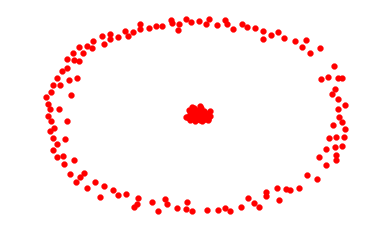

In [68]:
# plot network 
spring_pos = nx.spring_layout(G)

plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, with_labels = False, node_size = 35)

We see from the plot that we have a bunch of nodes that are highly connected and another set of nodes that have very few if any connections.  

Let us look at the degree centrality to determine the range of degrees for the nodes in the graph.  


#### Degree Centrality for entire graph  

In [69]:
#Compute Degree
deg=nx.degree(G)

print('Degree Range: ' + str(min(deg.values())) + ' ' + str(max(deg.values()))) 

Degree Range: 0 328


This represent quite a spread.  We will drop from the graph nodes with degree less than 25.  

### Subgraph for Analysis

In [70]:
#https://glowingpython.blogspot.com/search?q=networkx

def trim_nodes(G,d):
 """ returns a copy of G without the nodes with a degree less than d """
 Gt = G.copy()
 dn = nx.degree(Gt)
 for n in Gt.nodes():
  if dn[n] <= d:
   Gt.remove_node(n)
 return Gt

# Trim the network to nodes with a minimum degree of 25
Gt = trim_nodes(G, 25)

The rest of the analysis will be done on this subgraph.  

#### Basic subgraph information and plot

In [71]:
print(nx.info(Gt))
print('Graph density: ' + str(nx.density(Gt)))
print('Is connected: ' + str(nx.is_connected(Gt)))

Name: 
Type: Graph
Number of nodes: 337
Number of edges: 17972
Average degree: 106.6588
Graph density: 0.317436766992
Is connected: True


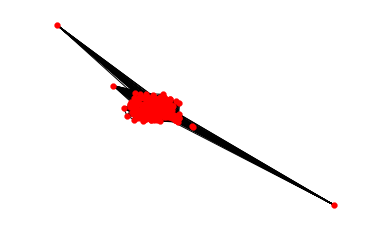

In [73]:
# plot subgraph 
spring_pos = nx.spring_layout(Gt)

plt.axis("off")
nx.draw_networkx(Gt, pos = spring_pos, with_labels = False, node_size = 35)

#### Determine Centrality Measures

In [74]:
# Calculate Centrality Measures 

## Degree Centrality
deg = nx.degree_centrality(Gt)

## Betweeness Centrality
bet = nx.betweenness_centrality(Gt)

# Closeness Centrality
clos = nx.closeness_centrality(Gt)

## Eigenvector Centrality
eig = nx.eigenvector_centrality(Gt)

centrality_measures = {
    'degree': deg,
    'eigenvector': eig,
    'betweenness': bet,
    'closeness': clos
}
centrality_df = pd.DataFrame(centrality_measures)

#centrality_df

centrality_df.sort_values(by=['degree', 'eigenvector'], ascending=[0, 0]).head(10)

,betweenness,closeness,degree,eigenvector
sIyHTizqAiGu12XMLX3N3g,0.021574,0.900804,0.889881,0.117351
aGbjLWzcrnEx2ZmMCFm3EA,0.019791,0.868217,0.848214,0.114796
4bEjOyTaDG24SY5TxsaUNQ,0.017573,0.861538,0.839286,0.121946
zt1TpTuJ6y9n551sw9TaEg,0.015763,0.850633,0.824405,0.106816
2e2e7WgqU1BnpxmQL5jbfw,0.015060,0.837905,0.806548,0.115464
ateowLnq6kpgNNWHzCDByQ,0.014169,0.821516,0.782738,0.107515
Xhg93cMdemu5pAMkDoEdtQ,0.013013,0.813559,0.770833,0.088475
BqrTtox0JbG-P_DKBB5bBw,0.012047,0.805755,0.758929,0.107834
tFU2Js_nbIZOrnKfYJYBBg,0.009423,0.788732,0.732143,0.106701
s5-VDvUqyYnD8RG3LPqnbQ,0.009490,0.785047,0.726190,0.105339


#### Apply centrality measures to the node 

In [75]:
# Assign each to an attribute in your network
nx.set_node_attributes(Gt, 'degree', deg)
nx.set_node_attributes(Gt, 'eigenvector', eig)
nx.set_node_attributes(Gt, 'betweenness', bet)
nx.set_node_attributes(Gt, 'closeness', clos)

#### Analysis  

Now that we have evaluated the various centrality measures, we will add them as attributes to the nodes in order to facilitate further analysis.  

In [76]:
# create a data frame of the node attributes including the centrality measures

node_attr_df = pd.DataFrame([nx.get_node_attributes(Gt,'name'), 
                             nx.get_node_attributes(Gt, 'rating'),
                             nx.get_node_attributes(Gt,'delivery'),
                             nx.get_node_attributes(Gt,'takeout'),
                             nx.get_node_attributes(Gt,'waiterservice'),
                             nx.get_node_attributes(Gt,'degree'),
                             nx.get_node_attributes(Gt,'eigenvector'),
                             nx.get_node_attributes(Gt,'betweenness'),
                             nx.get_node_attributes(Gt,'closeness')]).transpose()

# change column names to appropriate names
node_attr_df.columns = ['name', 'rating', 'delivery', 'takeout', 'waiterservice', 'degree', 'eigenvector', 'betweenness', 'closeness']

# name the index
#node_attr_df.index.names = ['business_id']

# make sure centrality measures are numeric
node_attr_df = node_attr_df.apply(pd.to_numeric,errors='ignore')

# the edgelist introduced a few businesses without rating and other associated information; drop these rows
node_attr_df = node_attr_df.dropna() 

In [77]:
node_attr_df.head(5)

,name,rating,delivery,takeout,waiterservice,degree,eigenvector,betweenness,closeness
-2n-OHbbwIv3SY8RP9bgTQ,Maggiano's Little Italy,4.0,Yes,Yes,Yes,0.401786,0.061277,0.003080,0.625698
-5RN56jH78MV2oquLV_G8g,Picasso,4.5,No,No,Yes,0.324405,0.059292,0.000941,0.596803
-j68F3i6vq1K7Fj9HuncHQ,The SLS Buffet,3.5,No,No,Yes,0.247024,0.043181,0.000446,0.570458
05tazaFQt1EnQ_Gk_1AFyg,Nine Fine Irishmen,4.0,No,No,Yes,0.407738,0.060474,0.002397,0.628037
0InQd9vuhRc98OksC3Ks8Q,Buffet Roundtable,2.0,No,No,No,0.145833,0.017459,0.000398,0.539326


For each of the attributes we are considering; delivery (yes, no, unknown), takeout (yes, no, unkown), WaiterService (yes, no, unknown), and rating (1-5), we will compute minimum, maximum, mean, median for eigenvector and degree centrality.  

In [78]:
delivery =  node_attr_df.groupby(['delivery']).agg({
                                                    "eigenvector": {
                                                                     "MinEigenvector":    "min",
                                                                     "AvgEigenvector":    "mean",
                                                                     "MedianEigenvector": "median",
                                                                     "MaxEigenvector":    "max" },
                                                                     
                                                    "degree":      {
                                                                     "MinDegree":         "min",
                                                                     "AvgDegree":         "mean",
                                                                     "MedianDegree":      "median",
                                                                     "MaxDegree":         "max"  },
    
                                                    "name":        {
                                                                     "count":             "count"}}) 

delivery

degree                                        eigenvector  \
         AvgDegree MaxDegree MinDegree MedianDegree MedianEigenvector   
delivery                                                                
No        0.321476  0.889881  0.062500     0.293155          0.046405   
Unknown   0.095238  0.095238  0.095238     0.095238          0.015045   
Yes       0.264456  0.425595  0.080357     0.288690          0.035531   

                                                       name  
         AvgEigenvector MaxEigenvector MinEigenvector count  
delivery                                                     
No             0.049381       0.121946       0.007304   312  
Unknown        0.015045       0.015045       0.015045     1  
Yes            0.038870       0.066517       0.012796     7

In [79]:
takeout =  node_attr_df.groupby(['takeout']).agg({
                                                    "eigenvector": {
                                                                     "MinEigenvector":    "min",
                                                                     "AvgEigenvector":    "mean",
                                                                     "MedianEigenvector": "median",
                                                                     "MaxEigenvector":    "max" },
                                                    "degree":      {
                                                                     "MinDegree":         "min",
                                                                     "AvgDegree":         "mean",
                                                                     "MedianDegree":      "median",
                                                                     "MaxDegree":         "max"  }, 
    
                                                    "name":        {
                                                                     "count":             "count"}}) 

takeout

degree                                        eigenvector  \
        AvgDegree MaxDegree MinDegree MedianDegree MedianEigenvector   
takeout                                                                
No       0.343049  0.889881  0.074405     0.312500          0.051744   
Unknown  0.095238  0.095238  0.095238     0.095238          0.015045   
Yes      0.306277  0.848214  0.062500     0.278274          0.042190   

                                                      name  
        AvgEigenvector MaxEigenvector MinEigenvector count  
takeout                                                     
No            0.053855       0.121946       0.007304   121  
Unknown       0.015045       0.015045       0.015045     1  
Yes           0.046275       0.115464       0.008239   198

In [80]:
waiterservice =  node_attr_df.groupby(['waiterservice']).agg({
                                                    "eigenvector": {
                                                                     "MinEigenvector":    "min",
                                                                     "AvgEigenvector":    "mean",
                                                                     "MedianEigenvector": "median",
                                                                     "MaxEigenvector":    "max" },
                                                    "degree":      {
                                                                     "MinDegree":         "min",
                                                                     "AvgDegree":         "mean",
                                                                     "MedianDegree":      "median",
                                                                     "MaxDegree":         "max"  }, 

                                                    "name":        {
                                                                     "count":             "count"}}) 


waiterservice

degree                                        eigenvector  \
              AvgDegree MaxDegree MinDegree MedianDegree MedianEigenvector   
waiterservice                                                                
No             0.256298  0.806548  0.077381     0.202381          0.030665   
Unknown        0.174603  0.258929  0.095238     0.169643          0.028368   
Yes            0.331031  0.889881  0.062500     0.303571          0.048723   

                                                            name  
              AvgEigenvector MaxEigenvector MinEigenvector count  
waiterservice                                                     
No                  0.039091       0.115464       0.008239    43  
Unknown             0.028571       0.042300       0.015045     3  
Yes                 0.050830       0.121946       0.007304   274

The majority of restaurants under consideration do not deliver, hence we are not able to evaluate whether this attribute has an impact on the centrality measures. Restaurants seemed to be pretty much evenly split with those that provide takeout and those who do not, there do not appear to have much difference in the average values for degree centrality or for Eigenvecor centrality. If we look at WaiterService however, it does appear that restaurants which provide this service have a higher centrality measures than those who do not. We will evaluate whether both these assumption are statistically true.  

#### two-sample t-test  

We will first consider degree centrality with respect to takeout, then we will consider it with respect to waiterserver.  

Our null hypothesis is that the mean of degree centrality for the group of restaurants with takeout is the same as for the group without.   

Let us consider each population:  

In [81]:
d_takeout_yes = node_attr_df[node_attr_df.takeout=='Yes'][['degree']]
d_takeout_no = node_attr_df[node_attr_df.takeout=='No'][['degree']]

stats.ttest_ind(a= d_takeout_yes,
                b= d_takeout_no,
                equal_var=False)  

Ttest_indResult(statistic=array([-1.87315408]), pvalue=array([ 0.0621882]))

Considering a 95% confidence interval, the p-value is greater than 5%, we cannot reject the null hypothesis at this time.  

We will now consider the attribute Waiter Service, our null hypothesis is that the mean of degree centrality for the group of restaurants with Waiter Service is the same as the group of restaurants without Waiter Service.

In [82]:
d_waiter_yes = node_attr_df[node_attr_df.waiterservice=='Yes'][['degree']]
d_waiter_no = node_attr_df[node_attr_df.waiterservice=='No'][['degree']]

stats.ttest_ind(a= d_waiter_yes,
                b= d_waiter_no,
                equal_var=False)  

Ttest_indResult(statistic=array([ 2.55002898]), pvalue=array([ 0.01363616]))

Considering a 95% confidence interval, the p-value is less than 5%, hence we would reject the null hypothesis and conclude that the difference in the mean of degree centrality between the restaurants with Waiter Service and with out is statistically significant.  

Let us repeat these tests for the Eigen vector centrality.  


In [83]:
e_takeout_yes = node_attr_df[node_attr_df.takeout=='Yes'][['eigenvector']]
e_takeout_no = node_attr_df[node_attr_df.takeout=='No'][['eigenvector']]

stats.ttest_ind(a= e_takeout_yes,
                b= e_takeout_no,
                equal_var=False)  

Ttest_indResult(statistic=array([-2.68193495]), pvalue=array([ 0.00780284]))

In [84]:
e_waiter_yes = node_attr_df[node_attr_df.waiterservice=='Yes'][['eigenvector']]
e_waiter_no = node_attr_df[node_attr_df.waiterservice=='No'][['eigenvector']]

stats.ttest_ind(a= e_waiter_yes,
                b= e_waiter_no,
                equal_var=False)   

Ttest_indResult(statistic=array([ 2.74931869]), pvalue=array([ 0.00811892]))

Again, considering a 95% confidence interval, the p-values in both cases are less than 5%, hence we would reject both null hypothesis and conclude that the difference in the mean of Eigen vector centrality between the restaurants with Waiter Service and without and the mean of Eigen vecor centrality between restaurants with takeout and without are statistically significant. 

In [85]:
rating =  node_attr_df.groupby(['rating']).agg({
                                                    "eigenvector": {
                                                                     "MinEigenvector":    "min",
                                                                     "AvgEigenvector":    "mean",
                                                                     "MedianEigenvector": "median",
                                                                     "MaxEigenvector":    "max" },
                                                    "degree":      {
                                                                     "MinDegree":         "min",
                                                                     "AvgDegree":         "mean",
                                                                     "MedianDegree":      "median",
                                                                     "MaxDegree":         "max"  }, 
                                                   
                                                    "name":        {
                                                                     "count":             "count"}}) 


rating

degree                                        eigenvector  \
       AvgDegree MaxDegree MinDegree MedianDegree MedianEigenvector   
rating                                                                
1.5     0.244048  0.244048  0.244048     0.244048          0.028049   
2.0     0.245833  0.437500  0.077381     0.252976          0.032221   
2.5     0.195489  0.386905  0.074405     0.202381          0.025198   
3.0     0.273224  0.770833  0.077381     0.252976          0.037481   
3.5     0.290737  0.824405  0.062500     0.281250          0.043260   
4.0     0.398455  0.889881  0.074405     0.389881          0.062495   
4.5     0.338370  0.806548  0.110119     0.300595          0.052607   

                                                     name  
       AvgEigenvector MaxEigenvector MinEigenvector count  
rating                                                     
1.5          0.028049       0.028049       0.028049     1  
2.0          0.031399       0.056782       0.011757     5  
2.5          0.027056       0.052202       0.007304    19  
3.0          0.038788       0.088475       0.011829    61  
3.5          0.044707       0.107515       0.008239   112  
4.0          0.063171       0.121946       0.010622   109  
4.5          0.056615       0.115464       0.020123    13

### Relationship Between Centrality Measures and Rating Values

Let's look to see if there's any indication of a relationship between degree and eigenvalue centrality and the rating score of a restaurant in "The Strip" neighborhood.

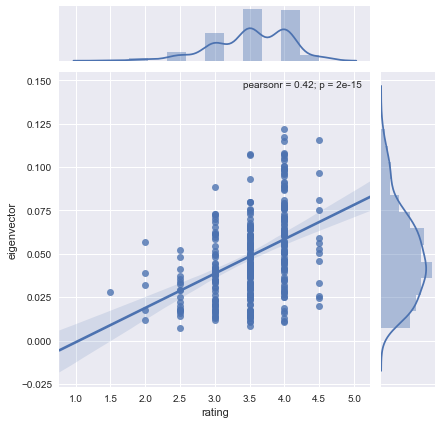

In [86]:
# eigenvector
sns.jointplot(x="rating", y="eigenvector", data=node_attr_df, kind="reg");

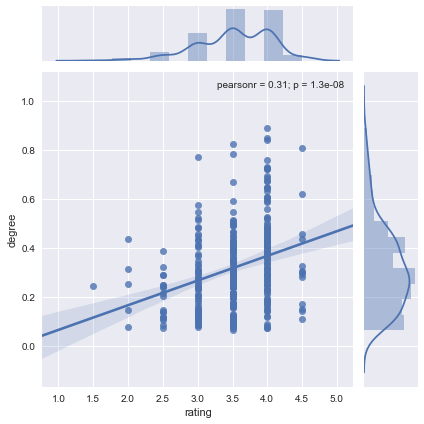

In [87]:
# degree
sns.jointplot(x="rating", y="degree", data=node_attr_df, kind="reg");

There does appear to be some correlation between these centrality scores and rating.  Eigenvector centrality has a slightly stronger correlation with a pearsonr value of 0.49.

In [88]:
# let's look at the correlation
node_attr_df.corr()

,rating,degree,eigenvector,betweenness,closeness
rating,1.000000,0.311412,0.424383,0.235666,0.302212
degree,0.311412,1.000000,0.981098,0.876699,0.988047
eigenvector,0.424383,0.981098,1.000000,0.815187,0.958057
betweenness,0.235666,0.876699,0.815187,1.000000,0.937397
closeness,0.302212,0.988047,0.958057,0.937397,1.000000


#### Convert the ratings score to a categorical variable, assuming a value based on the specific ranges of ratings:

Ranges:
* Excellent : 4 - 5 
* Good      : 3 - 3.99 
* Fair      : 2 - 2.99 
* Poor      : 1 - 1.99 

In [89]:
# create a column to store a categorical variable of the group
node_attr_df = node_attr_df.assign(rating_group = "")

In [90]:
# assign the rating_group based on the ranges above

node_attr_df.loc[node_attr_df.rating >= 4, 'rating_group'] = 'Excellent'
node_attr_df.loc[(node_attr_df.rating >= 3) & (node_attr_df.rating < 4), 'rating_group'] = 'Good'
node_attr_df.loc[(node_attr_df.rating >= 2) & (node_attr_df.rating < 3), 'rating_group'] = 'Fair'
node_attr_df.loc[(node_attr_df.rating >= 1) & (node_attr_df.rating < 2), 'rating_group'] = 'Poor'

node_attr_df['rating_group'] = pd.Categorical(node_attr_df.rating_group)

In [91]:
rating_group =  node_attr_df.groupby(['rating_group']).agg({
                                                    "eigenvector": {
                                                                     "MinEigenvector":    "min",
                                                                     "AvgEigenvector":    "mean",
                                                                     "MaxEigenvector":    "max" },
                                                    "degree":      {
                                                                     "MinDegree":         "min",
                                                                     "AvgDegree":         "mean",
                                                                     "MaxDegree":         "max"  },

                                                    "name":        {
                                                                     "count":             "count"}}) 

rating_group

degree                        eigenvector                 \
             AvgDegree MaxDegree MinDegree AvgEigenvector MaxEigenvector   
rating_group                                                               
Excellent     0.392052  0.889881  0.074405       0.062472       0.121946   
Fair          0.205977  0.437500  0.074405       0.027960       0.056782   
Good          0.284562  0.824405  0.062500       0.042620       0.107515   
Poor          0.244048  0.244048  0.244048       0.028049       0.028049   

                             name  
             MinEigenvector count  
rating_group                       
Excellent          0.010622   122  
Fair               0.007304    24  
Good               0.008239   173  
Poor               0.028049     1

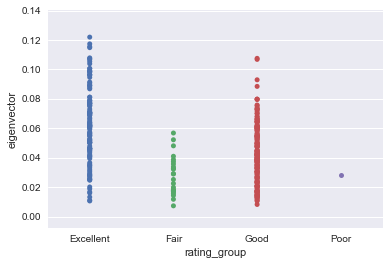

In [92]:
sns.stripplot(x="rating_group", y="eigenvector", data=node_attr_df);

plt.show()

In [93]:

excellent_ratings = node_attr_df[node_attr_df.rating_group=='Excellent'].rating
                          
fair_ratings = node_attr_df[node_attr_df.rating_group=='Fair'].rating

stats.ttest_ind(a= excellent_ratings,
                b= fair_ratings,
                equal_var=False)

Ttest_indResult(statistic=37.159989414625656, pvalue=1.5395874781974362e-25)

Higher Eigen vector centrality score are closely related to higher ratings. We can infere that people are more likely to post positive reviews for restaurants. 